# Classifying Hate Speech using the LSTM Architecture

Implemented models:
- Dense Sequential Network
- LSTM
- BiLSTM
- GRU

Models are currently overfitting :(

Reference:
- https://nzlul.medium.com/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad

In [5]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Train test split
from sklearn.model_selection import train_test_split

# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC

# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

In [6]:
from dataset.dataset import Dataset
from constants import *

In [7]:
from collections import Counter
import time

In [8]:
RANDOM_SEED = 0

In [9]:
# Load cleaned dataset
dataset = Dataset(full_data_path=CLEANED_DATASET_PATH,
                  from_scratch=False,
                  split_sizes=split_sizes_cleaned)
dataset.build()

X_train = dataset.get_features(split_type="train")
Y_train = dataset.get_labels(split_type="train")
X_val = dataset.get_features(split_type="val")
Y_val = dataset.get_labels(split_type="val")
X_test = dataset.get_features(split_type="test")
Y_test = dataset.get_labels(split_type="test")

Data loaded from dataset/cleaned_dataset.pkl


In [10]:
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)

In [45]:
Y_train = Y_train.astype('float32')
Y_val = Y_val.astype('float32')
Y_test = Y_test.astype('float32')

## Tokenization

In [11]:
tokenizer = Tokenizer(char_level = False,
                      oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)

In [12]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

14120

In [13]:
word_counts = tokenizer.word_counts

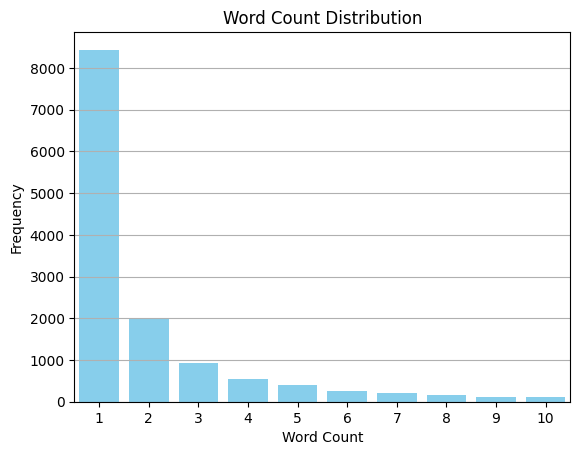

In [14]:
# Count distribution
count_distribution = Counter(word_counts.values())

# Plot count distribution
max_word_count = 10  # Maximum word count to consider
plt.bar(*zip(*sorted(count_distribution.items())), color='skyblue')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.xticks(range(1, max_word_count + 1))
plt.xlim(0.5, max_word_count + 0.5)  # Adjust x-axis limit
plt.grid(axis='y')
plt.show()

We have a significant number of words that occur only once, so we exclude them from the vocab.

In [15]:
# Filter out words occurring only once
filtered_words = [word for word, count in word_counts.items() if count > 1]

# Create a new tokenizer with filtered words
tokenizer = Tokenizer(char_level = False,
                      oov_token = '<OOV>')
tokenizer.fit_on_texts(filtered_words)

# Get the word_index
word_index = tokenizer.word_index
print(len(word_index)) # note that we dont use index 0

5680


# Sequence and Padding

We convert the tweets in the training, validation, and test sets into a sequence of numbers. Afterwards, we add padding to the sequences to ensure the same length for all sequences.

In [16]:
# Define parameters
max_len = 25
padding_type = 'post' 
trunc_type = 'post' 

In [17]:
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = 25,
                                padding = 'post',
                                truncating = 'post')

In [18]:
validation_sequences = tokenizer.texts_to_sequences(X_val)
validation_padded = pad_sequences(validation_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [19]:
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,
                            maxlen = max_len,
                            padding = padding_type,
                            truncating = trunc_type)

In [20]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of validation tensor: ', validation_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)


Shape of training tensor:  (8674, 25)
Shape of validation tensor:  (3859, 25)
Shape of testing tensor:  (3976, 25)


# Dense Classifier

In [42]:
# Define parameter
vocab_size = 5681 
embedding_dim = 16
drop_value = 0.2
n_dense = 24
max_len = 25

# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(input_dim = vocab_size,
                    output_dim = embedding_dim))
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))
model.build(input_shape=(None,max_len))
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 25, 16)         │        90,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,329 (356.75 KB)

 Trainable params: 91,329 (356.75 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Define additional metrics
import tensorflow.keras.backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))


In [65]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

In [66]:
start_time = time.time()

num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded,
                    Y_train,
                    epochs=num_epochs, 
                    validation_data=(testing_padded, Y_test),
                    callbacks =[early_stop],
                    verbose=2)

end_time = time.time()
training_runtime = end_time - start_time


Epoch 1/30
272/272 - 1s - 4ms/step - accuracy: 0.9575 - auc_2: 0.9931 - loss: 0.1060 - precision_2: 0.9575 - recall_2: 0.9550 - val_accuracy: 0.7256 - val_auc_2: 0.7858 - val_loss: 1.2868 - val_precision_2: 0.7477 - val_recall_2: 0.6584
Epoch 2/30
272/272 - 0s - 1ms/step - accuracy: 0.9617 - auc_2: 0.9941 - loss: 0.0984 - precision_2: 0.9613 - recall_2: 0.9599 - val_accuracy: 0.7241 - val_auc_2: 0.7839 - val_loss: 1.3754 - val_precision_2: 0.7473 - val_recall_2: 0.6543
Epoch 3/30
272/272 - 0s - 1ms/step - accuracy: 0.9593 - auc_2: 0.9937 - loss: 0.1012 - precision_2: 0.9615 - recall_2: 0.9545 - val_accuracy: 0.7108 - val_auc_2: 0.7826 - val_loss: 1.3574 - val_precision_2: 0.6844 - val_recall_2: 0.7530
Epoch 4/30
272/272 - 0s - 1ms/step - accuracy: 0.9547 - auc_2: 0.9932 - loss: 0.1059 - precision_2: 0.9533 - recall_2: 0.9535 - val_accuracy: 0.7226 - val_auc_2: 0.7793 - val_loss: 1.3867 - val_precision_2: 0.7562 - val_recall_2: 0.6346


In [68]:
train_dense_results = model.evaluate(training_padded, np.asarray(Y_train), verbose=2, batch_size=256)
test_start = time.time()
test_dense_results = model.evaluate(testing_padded, np.asarray(Y_test), verbose=2, batch_size=256)
test_end = time.time()
inference_time = test_end - test_start
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Test accuracy: {test_dense_results[1]*100:0.2f}')
print(f'Test precision: {test_dense_results[2]*100:0.2f}')
print(f'Test recall: {test_dense_results[3]*100:0.2f}')
print(f'Test AUC: {test_dense_results[4]*100:0.2f}')
print(f'Training Time: {training_runtime}')
print(f'Inference Time: {inference_time}')



34/34 - 0s - 953us/step - accuracy: 0.9543 - auc_2: 0.9966 - loss: 0.1073 - precision_2: 0.9918 - recall_2: 0.9137
16/16 - 0s - 1ms/step - accuracy: 0.7226 - auc_2: 0.7793 - loss: 1.3867 - precision_2: 0.7562 - recall_2: 0.6346
Train accuracy: 95.43
Test accuracy: 72.26
Test precision: 75.62
Test recall: 63.46
Test AUC: 77.93
Training Time: 2.005986213684082
Inference Time: 0.03864908218383789


## LSTM

In [69]:
# Define parameter
vocab_size = 5681 
embedding_dim = 16
n_lstm = 128
drop_lstm = 0.2
max_len = 25

# Define LSTM Model 
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim))
model1.add(SpatialDropout1D(drop_lstm))
model1.add(LSTM(n_lstm, return_sequences=False))
model1.add(Dropout(drop_lstm))
model1.add(Dense(1, activation='sigmoid'))
model1.build(input_shape=(None,max_len))
model1.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 25, 16)         │        90,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 25, 16)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,265 (645.57 KB)

 Trainable params: 165,265 (645.57 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

In [73]:
start_time = time.time()

num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model1.fit(training_padded,
                     Y_train,
                     epochs=num_epochs, 
                     validation_data=(testing_padded, Y_test),
                     callbacks =[early_stop],
                     verbose=2)

end_time = time.time()
training_time_lstm = end_time - start_time

Epoch 1/30
272/272 - 4s - 15ms/step - accuracy: 0.9297 - auc_3: 0.9783 - loss: 0.1789 - precision_3: 0.9394 - recall_3: 0.9144 - val_accuracy: 0.7248 - val_auc_3: 0.7964 - val_loss: 0.7963 - val_precision_3: 0.7670 - val_recall_3: 0.6243
Epoch 2/30
272/272 - 4s - 15ms/step - accuracy: 0.9343 - auc_3: 0.9807 - loss: 0.1702 - precision_3: 0.9453 - recall_3: 0.9180 - val_accuracy: 0.7274 - val_auc_3: 0.7944 - val_loss: 0.7798 - val_precision_3: 0.7234 - val_recall_3: 0.7121
Epoch 3/30
272/272 - 4s - 15ms/step - accuracy: 0.9337 - auc_3: 0.9811 - loss: 0.1671 - precision_3: 0.9388 - recall_3: 0.9239 - val_accuracy: 0.7266 - val_auc_3: 0.7884 - val_loss: 0.9010 - val_precision_3: 0.7390 - val_recall_3: 0.6775
Epoch 4/30
272/272 - 4s - 15ms/step - accuracy: 0.9435 - auc_3: 0.9855 - loss: 0.1445 - precision_3: 0.9533 - recall_3: 0.9294 - val_accuracy: 0.7178 - val_auc_3: 0.7867 - val_loss: 0.8983 - val_precision_3: 0.6908 - val_recall_3: 0.7607
Epoch 5/30
272/272 - 4s - 14ms/step - accuracy: 

In [74]:
train_lstm_results = model1.evaluate(training_padded, np.asarray(Y_train), verbose=2, batch_size=256)
test_start = time.time()
test_lstm_results = model1.evaluate(testing_padded, np.asarray(Y_test), verbose=2, batch_size=256)
test_end = time.time()
inference_time_lstm = test_end - test_start
print(f'Train accuracy: {train_lstm_results[1]*100:0.2f}')
print(f'Test accuracy: {test_lstm_results[1]*100:0.2f}')
print(f'Test precision: {test_lstm_results[2]*100:0.2f}')
print(f'Test recall: {test_lstm_results[3]*100:0.2f}')
print(f'Test AUC: {test_lstm_results[4]*100:0.2f}')
print(f'Training Time: {training_time_lstm}')
print(f'Inference Time: {inference_time_lstm}')



34/34 - 1s - 19ms/step - accuracy: 0.9587 - auc_3: 0.9917 - loss: 0.1017 - precision_3: 0.9682 - recall_3: 0.9462
16/16 - 0s - 20ms/step - accuracy: 0.7226 - auc_3: 0.7812 - loss: 1.0246 - precision_3: 0.7196 - recall_3: 0.7044
Train accuracy: 95.87
Test accuracy: 72.26
Test precision: 71.96
Test recall: 70.44
Test AUC: 78.12
Training Time: 27.648517847061157
Inference Time: 0.3473677635192871


## BiLSTM

In [75]:
# Define parameter
vocab_size = 5681 
embedding_dim = 16
n_lstm = 128
drop_lstm = 0.2
max_len = 25


model2 = Sequential()
model2.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model2.add(Bidirectional(LSTM(n_lstm,
                              return_sequences = False)))
model2.add(Dropout(drop_lstm))
model2.add(Dense(1, activation='sigmoid'))
model2.build(input_shape=(None,max_len))
model2.summary()


/Users/cayasryan/.pyenv/versions/3.11.2/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 25, 16)         │        90,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       148,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239,633 (936.07 KB)

 Trainable params: 239,633 (936.07 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

In [77]:
start_time = time.time()

num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model2.fit(training_padded,
                     Y_train,
                     epochs=num_epochs, 
                     validation_data=(testing_padded, Y_test),
                     callbacks =[early_stop],
                     verbose=2)

end_time = time.time()
training_time_bilstm = end_time - start_time

Epoch 1/30
272/272 - 8s - 29ms/step - accuracy: 0.6458 - auc_4: 0.7142 - loss: 0.6105 - precision_4: 0.6632 - recall_4: 0.5522 - val_accuracy: 0.7279 - val_auc_4: 0.8153 - val_loss: 0.5325 - val_precision_4: 0.7960 - val_recall_4: 0.5928
Epoch 2/30
272/272 - 8s - 29ms/step - accuracy: 0.8044 - auc_4: 0.8862 - loss: 0.4238 - precision_4: 0.8146 - recall_4: 0.7738 - val_accuracy: 0.7485 - val_auc_4: 0.8326 - val_loss: 0.5100 - val_precision_4: 0.7570 - val_recall_4: 0.7116
Epoch 3/30
272/272 - 7s - 27ms/step - accuracy: 0.8386 - auc_4: 0.9123 - loss: 0.3746 - precision_4: 0.8508 - recall_4: 0.8101 - val_accuracy: 0.7372 - val_auc_4: 0.8084 - val_loss: 0.5453 - val_precision_4: 0.8035 - val_recall_4: 0.6088
Epoch 4/30
272/272 - 7s - 26ms/step - accuracy: 0.8764 - auc_4: 0.9462 - loss: 0.2989 - precision_4: 0.8990 - recall_4: 0.8402 - val_accuracy: 0.7497 - val_auc_4: 0.8270 - val_loss: 0.5717 - val_precision_4: 0.7652 - val_recall_4: 0.7008
Epoch 5/30
272/272 - 7s - 26ms/step - accuracy: 

In [102]:
train_bilstm_results = model2.evaluate(training_padded, np.asarray(Y_train), verbose=2, batch_size=256)
test_start = time.time()
test_bilstm_results = model2.evaluate(testing_padded, np.asarray(Y_test), verbose=2, batch_size=256)
test_end = time.time()
inference_time_bilstm = test_end - test_start
print(f'Train accuracy: {train_bilstm_results[1]*100:0.2f}')
print(f'Test accuracy: {test_bilstm_results[1]*100:0.2f}')
print(f'Test precision: {test_bilstm_results[2]*100:0.2f}')
print(f'Test recall: {test_bilstm_results[3]*100:0.2f}')
print(f'Test AUC: {test_bilstm_results[4]*100:0.2f}')
print(f'Training Time: {training_time_bilstm}')
print(f'Inference Time: {inference_time_bilstm}')



34/34 - 1s - 34ms/step - accuracy: 0.9442 - auc_4: 0.9875 - loss: 0.1444 - precision_4: 0.9393 - recall_4: 0.9464
16/16 - 1s - 37ms/step - accuracy: 0.7347 - auc_4: 0.8057 - loss: 0.8745 - precision_4: 0.7222 - recall_4: 0.7390
Train accuracy: 94.42
Test accuracy: 73.47
Test precision: 72.22
Test recall: 73.90
Test AUC: 80.57
Training Time: 51.723658084869385
Inference Time: 0.6214849948883057


## GRU

In [98]:
model3 = Sequential()
model3.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model3.add(SpatialDropout1D(0.2))
model3.add(GRU(128, return_sequences = False))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation = 'sigmoid'))

model3.build(input_shape=(None,max_len))
model3.summary()

/Users/cayasryan/.pyenv/versions/3.11.2/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 25, 16)         │        90,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ (None, 25, 16)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        56,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,089 (574.57 KB)

 Trainable params: 147,089 (574.57 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

In [105]:
start_time = time.time()

num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model3.fit(training_padded,
                     Y_train,
                     epochs=num_epochs, 
                     validation_data=(testing_padded, Y_test),
                     callbacks =[early_stop],
                     verbose=2)

end_time = time.time()
training_time_gru = end_time - start_time

Epoch 1/30
272/272 - 4s - 16ms/step - accuracy: 0.9743 - auc_5: 0.9977 - loss: 0.0559 - precision_5: 0.9787 - recall_5: 0.9682 - val_accuracy: 0.7165 - val_auc_5: 0.7616 - val_loss: 1.5466 - val_precision_5: 0.7059 - val_recall_5: 0.7158
Epoch 2/30
272/272 - 4s - 16ms/step - accuracy: 0.9758 - auc_5: 0.9981 - loss: 0.0527 - precision_5: 0.9810 - recall_5: 0.9689 - val_accuracy: 0.7155 - val_auc_5: 0.7572 - val_loss: 1.6396 - val_precision_5: 0.7043 - val_recall_5: 0.7163
Epoch 3/30
272/272 - 4s - 16ms/step - accuracy: 0.9752 - auc_5: 0.9978 - loss: 0.0547 - precision_5: 0.9785 - recall_5: 0.9704 - val_accuracy: 0.7148 - val_auc_5: 0.7637 - val_loss: 1.5118 - val_precision_5: 0.7020 - val_recall_5: 0.7194
Epoch 4/30
272/272 - 4s - 16ms/step - accuracy: 0.9786 - auc_5: 0.9982 - loss: 0.0496 - precision_5: 0.9816 - recall_5: 0.9742 - val_accuracy: 0.7103 - val_auc_5: 0.7547 - val_loss: 1.6483 - val_precision_5: 0.6968 - val_recall_5: 0.7163
Epoch 5/30
272/272 - 4s - 15ms/step - accuracy: 

In [106]:
train_gru_results = model3.evaluate(training_padded, np.asarray(Y_train), verbose=2, batch_size=256)
test_start = time.time()
test_gru_results = model3.evaluate(testing_padded, np.asarray(Y_test), verbose=2, batch_size=256)
test_end = time.time()
inference_time_gru = test_end - test_start
print(f'Train accuracy: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy: {test_gru_results[1]*100:0.2f}')
print(f'Test precision: {test_gru_results[2]*100:0.2f}')
print(f'Test recall: {test_gru_results[3]*100:0.2f}')
print(f'Test AUC: {test_gru_results[4]*100:0.2f}')
print(f'Training Time: {training_time_gru}')
print(f'Inference Time: {inference_time_gru}')



34/34 - 1s - 16ms/step - accuracy: 0.9738 - auc_5: 0.9989 - loss: 0.0507 - precision_5: 0.9520 - recall_5: 0.9964
16/16 - 0s - 17ms/step - accuracy: 0.7045 - auc_5: 0.7556 - loss: 1.6028 - precision_5: 0.6668 - recall_5: 0.7850
Train accuracy: 97.38
Test accuracy: 70.45
Test precision: 66.68
Test recall: 78.50
Test AUC: 75.56
Training Time: 33.92593717575073
Inference Time: 0.29160594940185547
